<a href="https://colab.research.google.com/github/geopan2000/Exploring-Mental-Health-Data/blob/main/Mental-Health-Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
# Clone the GitHub repository
!git clone https://github.com/geopan2000/Exploring-Mental-Health-Data.git

# Change directory to the cloned repository
%cd Exploring-Mental-Health-Data

Cloning into 'Exploring-Mental-Health-Data'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 30 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 5.28 MiB | 3.27 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/Exploring-Mental-Health-Data/Exploring-Mental-Health-Data/Exploring-Mental-Health-Data/Exploring-Mental-Health-Data/Exploring-Mental-Health-Data/Exploring-Mental-Health-Data


In [89]:
import pandas as pd
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb
import pandas as pd
from sklearn.metrics import classification_report

In [90]:
train_set = pd.read_csv('/content/Exploring-Mental-Health-Data/data/train.csv')
test_set = pd.read_csv('/content/Exploring-Mental-Health-Data/data/test.csv')

In [91]:
train_set.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


# Data Inspection

In [92]:
train_print = train_set.copy()
train_print = train_print.drop(columns=['Depression'])

for column in train_print.columns:
    train_nan_ratio = train_print[column].isna().sum() / len(train_print)  # Proportion of NaN in train set
    test_nan_ratio = test_set[column].isna().sum() / len(test_set)  # Proportion of NaN in test set
    print(f"{column}  Train Set: {train_nan_ratio:.2%} Test Set: {test_nan_ratio:.2%}")

id  Train Set: 0.00% Test Set: 0.00%
Name  Train Set: 0.00% Test Set: 0.00%
Gender  Train Set: 0.00% Test Set: 0.00%
Age  Train Set: 0.00% Test Set: 0.00%
City  Train Set: 0.00% Test Set: 0.00%
Working Professional or Student  Train Set: 0.00% Test Set: 0.00%
Profession  Train Set: 26.03% Test Set: 26.26%
Academic Pressure  Train Set: 80.17% Test Set: 79.99%
Work Pressure  Train Set: 19.84% Test Set: 20.02%
CGPA  Train Set: 80.17% Test Set: 79.99%
Study Satisfaction  Train Set: 80.17% Test Set: 79.99%
Job Satisfaction  Train Set: 19.84% Test Set: 20.01%
Sleep Duration  Train Set: 0.00% Test Set: 0.00%
Dietary Habits  Train Set: 0.00% Test Set: 0.01%
Degree  Train Set: 0.00% Test Set: 0.00%
Have you ever had suicidal thoughts ?  Train Set: 0.00% Test Set: 0.00%
Work/Study Hours  Train Set: 0.00% Test Set: 0.00%
Financial Stress  Train Set: 0.00% Test Set: 0.00%
Family History of Mental Illness  Train Set: 0.00% Test Set: 0.00%


In [93]:
#for value in test_set['Sleep Duration'].unique():
 #print(value)

# Feature Engineering: Train Data


In [94]:
train_set.drop(columns=['Name', 'id'], inplace=True)

train_set['Gender'] = train_set['Gender'].map({'Male' : 1, 'Female' : 0}) #Always trasnforming 2 option object types into binary

train_set['Age'] = train_set['Age'] / 100 #Normalized by the Max value
train_set['Age'] = train_set['Age'].fillna(train_set['Age'].mean())

train_set['City'] = train_set['City'].fillna('X')
train_set['City_freq'] = train_set['City'].map(train_set['City'].value_counts()) # frequency encoding, 98 different cities
train_set = pd.get_dummies(train_set, columns=['City'])

train_set['Working Professional or Student'] = train_set['Working Professional or Student'].map({'Working Professional' : 1, 'Student' : 0}) #Always trasnforming 2 option object types into binary

train_set['Profession'] = train_set['Profession'].fillna('X')
train_set['Profession_freq'] = train_set['Profession'].map(train_set['Profession'].value_counts()) # frequency encoding
train_set = pd.get_dummies(train_set, columns=['Profession'])

# Create the new feature 'Academic/Work Pressure'
train_set['Academic/Work Pressure'] = train_set.apply(
    lambda row: row['Academic Pressure'] if pd.notna(row['Academic Pressure']) and pd.isna(row['Work Pressure']) else
                row['Work Pressure'] if pd.isna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) else
                (row['Academic Pressure'] + row['Work Pressure']) / 2 if pd.notna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) else
                None,  # Placeholder for rows where both are NaN
    axis=1)

# Fill any remaining NaN in 'Academic/Work Pressure' with its mean
train_set['Academic/Work Pressure'] = train_set['Academic/Work Pressure'].fillna(train_set['Academic/Work Pressure'].mean())

train_set['Academic Pressure'] = train_set['Academic Pressure'] / 5
train_set['Academic Pressure'] = train_set['Academic Pressure'].fillna(0)

train_set['Work Pressure'] = train_set['Work Pressure'] / 5
train_set['Work Pressure'] = train_set['Work Pressure'].fillna(0)

train_set['CGPA'] = train_set['CGPA'] /10
train_set['CGPA'] = train_set['CGPA'].fillna(0)

# Create the new feature 'Study/Job Satisfaction'
train_set['Study/Job Satisfaction'] = train_set.apply(
    lambda row: row['Study Satisfaction'] if pd.notna(row['Study Satisfaction']) and pd.isna(row['Job Satisfaction']) else
                row['Job Satisfaction'] if pd.isna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) else
                (row['Study Satisfaction'] + row['Job Satisfaction']) / 2 if pd.notna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) else
                None,  # Placeholder for rows where both are NaN
    axis=1)

# Fill any remaining NaN in 'Study/Job Satisfaction' with its mean
train_set['Study/Job Satisfaction'] = train_set['Study/Job Satisfaction'].fillna(train_set['Study/Job Satisfaction'].mean())

train_set['Study Satisfaction'] = train_set['Study Satisfaction'] / 5
train_set['Study Satisfaction'] = train_set['Study Satisfaction'].fillna(0)

train_set['Job Satisfaction'] = train_set['Job Satisfaction'] / 5
train_set['Job Satisfaction'] = train_set['Job Satisfaction'].fillna(0)

train_set['Degree'] = train_set['Degree'].fillna('X')
train_set['Degree_freq'] = train_set['Degree'].map(train_set['Degree'].value_counts()) # frequency encoding
train_set = pd.get_dummies(train_set, columns=['Degree'])

train_set['Have you ever had suicidal thoughts ?'] = train_set['Have you ever had suicidal thoughts ?'].map({'Yes' : 1, 'No' : 0}) #Always trasnforming 2 option object types into binary

train_set['Work/Study Hours'] = train_set['Work/Study Hours'] / 24 #Normalized by the Max value

train_set['Financial Stress'] = train_set['Financial Stress'] / 5 #Normalized by the Max value
train_set['Financial Stress'] = train_set['Financial Stress'].fillna(0)

train_set['Family History of Mental Illness'] = train_set['Family History of Mental Illness'].map({'Yes' : 1, 'No' : 0}) #Always trasnforming 2 option object types into binary

In [95]:
 #Define a function to encode Sleep Duration
def encode_sleep_duration(value):
    # Check for NaN or None
    if pd.isna(value):
        return -1  # Placeholder for missing or invalid values

    # Ensure the value is a string
    value = str(value).strip()

    # Encoding logic
    if 'Less than 5 hours' in value or value in ['3-4 hours', '4-5 hours', '2-3 hours']:
        return 1  # < 5 hours
    elif '5-6 hours' in value:
        return 2  # 5-6 hours
    elif '6-7 hours' in value or '6-8 hours' in value:
        return 3  # 6-7 hours
    elif '7-8 hours' in value:
        return 4  # 7-8 hours
    elif 'More than 8 hours' in value or '8-9 hours' in value or '9-11 hours' in value:
        return 5  # > 8 hours
    else:
        return -1  # Placeholder for other invalid or unclear values

sleep_mapping = {
    'More than 8 hours': '>8',
    'Less than 5 hours': '<5',
    'Moderate': '5-6 hours',
    '9-6 hours': '6-9 hours',

    '10-6 hours': '6-10 hours',
    'than 5 hours': '4-6 hours',
    'Unhealthy': '4-6 hours',
    '9-5 hours': '5-9 hours',
    '9-5': '5-9 hours',
    '8-89 hours': '8-9 hours',

    # Ambiguous or irrelevant entries
    'Sleep_Duration': None, '40-45 hours': None, '55-66 hours': None, 'Indore': None,
    '45': None, '35-36 hours': None, 'No': None, 'Indore': None, '49 hours': None,
    'Work_Study_Hours': None, '45-48 hours': None, 'Pune': None, 'Soham': None,
    '0': None, 'Meerut': None, '60-65 hours': None, 'Vivan': None,
    'Have_you_ever_had_suicidal_thoughts': None, '20-21 hours': None, '50-75 hours': None
}

# Define range extraction function
def extract_range(value):
    try:
        if '-' in value:
            parts = value.split('-')
            return int(parts[0]), int(parts[1].split()[0])
        elif '<' in value:
            return 3, 5
        elif '>' in value:
            lower_bound = int(value.split('>')[1].split()[0])
            return lower_bound, 10
        elif value.isdigit():
            num = int(value)
            return num, num
        else:
            return None, None
    except:
        return None, None

In [96]:
train_set['Sleep Duration'] = train_set['Sleep Duration'].map(sleep_mapping)
train_set['Sleep_Duration_Encoded'] = train_set['Sleep Duration'].apply(encode_sleep_duration)

# Apply the function to create 'From' and 'To' columns
train_set[['From', 'To']] = train_set['Sleep Duration'].apply(lambda x: pd.Series(extract_range(x)))

# Handle missing values
train_set['From'] = train_set['From'].fillna(train_set['From'].mean())
train_set['To'] = train_set['To'].fillna(train_set['To'].mean())

# Drop the original column if not needed
train_set.drop(columns=['Sleep Duration'], inplace=True)

In [97]:
# Define mapping for valid dietary habits
dietary_mapping = {
    'Moderate': 'Moderate',
    'Unhealthy': 'Unhealthy',
    'Healthy': 'Healthy',
    'More Healthy': 'Healthy',
    'Less Healthy': 'Unhealthy',
    'Less than Healthy': 'Unhealthy',
    'No Healthy': 'Unhealthy',
    '3': 'Moderate',
    '1.0': 'Unhealthy',
    '2': 'Moderate',
    '5 Healthy': 'Healthy',
    '5 Unhealthy': 'Unhealthy',

    # Ambiguous or irrelevant entries
    'Yes': None, 'No': None, 'No Healthy': None, 'Class 12': None, 'Indoor': None,
    'Male': None, 'Vegas': None, 'M.Tech': None, 'Electrician': None,
    'Hormonal': None, 'Mihir': None, 'Gender': None, 'BSc': None,
    'Pratham': None, 'Prachi': None, 'Resistant': None, 'Mealy': None,

    'nan': None, 'Academic': None, 'Educational': None, 'Soham': None,
    'Naina': None, 'Kolkata': None, 'Raghav': None, 'Vivaan': None,  'MCA': None,
}

# Apply the mapping to the Dietary Habits column
train_set['Dietary Habits'] = train_set['Dietary Habits'].map(dietary_mapping)
train_set['Dietary Habits'] = train_set['Dietary Habits'].fillna('X')
train_set['Dietary Habits_freq'] = train_set['Dietary Habits'].map(train_set['Dietary Habits'].value_counts()) # frequency encoding
train_set = pd.get_dummies(train_set, columns=['Dietary Habits']) # dummy variables

In [98]:
X = train_set.copy()
y = X['Depression']
X = X.drop(columns=['Depression'])

# Feature Engineering: Test Data

In [ ]:
id = test_set['id']
test_set.drop(columns=['Name', 'id'], inplace=True)

test_set['Gender'] = test_set['Gender'].map({'Male' : 1, 'Female' : 0}) #Always trasnforming 2 option object types into binary

test_set['Age'] = test_set['Age'] / 100 #Normalized by the Max value
test_set['Age'] = test_set['Age'].fillna(test_set['Age'].mean())

test_set['City'] = test_set['City'].fillna('X')
test_set['City_freq'] = test_set['City'].map(test_set['City'].value_counts()) # frequency encoding
test_set = pd.get_dummies(test_set, columns=['City'])

test_set['Working Professional or Student'] = test_set['Working Professional or Student'].map({'Working Professional' : 1, 'Student': 0}) #Always trasnforming 2 option object types into binary

test_set['Profession'] = test_set['Profession'].fillna('X')
test_set['Profession_freq'] = test_set['Profession'].map(test_set['Profession'].value_counts()) # frequency encoding
test_set = pd.get_dummies(test_set, columns=['Profession'])

# Create the new feature 'Academic/Work Pressure'
test_set['Academic/Work Pressure'] = test_set.apply(
    lambda row: row['Academic Pressure'] if pd.notna(row['Academic Pressure']) and pd.isna(row['Work Pressure']) else
                row['Work Pressure'] if pd.isna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) else
                (row['Academic Pressure'] + row['Work Pressure']) / 2 if pd.notna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) else
                None,  # Placeholder for rows where both are NaN
    axis=1)

# Fill any remaining NaN in 'Academic/Work Pressure' with its mean
test_set['Academic/Work Pressure'] = test_set['Academic/Work Pressure'].fillna(test_set['Academic/Work Pressure'].mean())

test_set['Academic Pressure'] = test_set['Academic Pressure'] / 5
test_set['Academic Pressure'] = test_set['Academic Pressure'].fillna(0)

test_set['Work Pressure'] = test_set['Work Pressure'] / 5
test_set['Work Pressure'] = test_set['Work Pressure'].fillna(0)

test_set['CGPA'] = test_set['CGPA'] /10
test_set['CGPA'] = test_set['CGPA'].fillna(0)

# Create the new feature 'Study/Job Satisfaction'
test_set['Study/Job Satisfaction'] = test_set.apply(
    lambda row: row['Study Satisfaction'] if pd.notna(row['Study Satisfaction']) and pd.isna(row['Job Satisfaction']) else
                row['Job Satisfaction'] if pd.isna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) else
                (row['Study Satisfaction'] + row['Job Satisfaction']) / 2 if pd.notna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) else
                None,  # Placeholder for rows where both are NaN
    axis=1)

# Fill any remaining NaN in 'Study/Job Satisfaction' with its mean
test_set['Study/Job Satisfaction'] = test_set['Study/Job Satisfaction'].fillna(train_set['Study/Job Satisfaction'].mean())

test_set['Study Satisfaction'] = test_set['Study Satisfaction'] / 5
test_set['Study Satisfaction'] = test_set['Study Satisfaction'].fillna(0)

test_set['Job Satisfaction'] = test_set['Job Satisfaction'] / 5
test_set['Job Satisfaction'] = test_set['Job Satisfaction'].fillna(0)

test_set['Degree'] = test_set['Degree'].fillna('X')
test_set['Degree_freq'] = test_set['Degree'].map(train_set['Degree'].value_counts()) # frequency encoding
test_set = pd.get_dummies(test_set, columns=['Degree'])

test_set['Have you ever had suicidal thoughts ?'] = test_set['Have you ever had suicidal thoughts ?'].map({'Yes' : 1, 'No' : 0}) #Always trasnforming 2 option object types into binary

test_set['Work/Study Hours'] = test_set['Work/Study Hours'] / 24 #Normalized by the Max value

test_set['Financial Stress'] = test_set['Financial Stress'] / 5 #Normalized by the Max value
test_set['Financial Stress'] = test_set['Financial Stress'].fillna(0)

test_set['Family History of Mental Illness'] = test_set['Family History of Mental Illness'].map({'Yes' : 1, 'No' : 0}) #Always trasnforming 2 option object types into binary

In [ ]:

test_set['Sleep Duration'] = test_set['Sleep Duration'].map(sleep_mapping)
test_set['Sleep_Duration_Encoded'] = test_set['Sleep Duration'].apply(encode_sleep_duration)

# Apply the function to create 'From' and 'To' columns
test_set[['From', 'To']] = test_set['Sleep Duration'].apply(lambda x: pd.Series(extract_range(x)))

# Handle missing values
test_set['From'] = test_set['From'].fillna(test_set['From'].mean())
test_set['To'] = test_set['To'].fillna(test_set['To'].mean())

# Drop the original column if not needed
test_set.drop(columns=['Sleep Duration'], inplace=True)

In [ ]:
test_set['Dietary Habits'] = test_set['Dietary Habits'].map(dietary_mapping)
test_set['Dietary Habits'] = test_set['Dietary Habits'].fillna('X')
test_set['Dietary Habits_freq'] = test_set['Dietary Habits'].map(train_set['Dietary Habits'].value_counts()) # frequency encoding
test_set = pd.get_dummies(test_set, columns=['Dietary Habits']) # dummy variables

In [11]:
model = XGBClassifier()
model.fit(X, y)

feature_importances = model.feature_importances_
important_features = X.columns[feature_importances > 0.005]
X_reduced = X[important_features]
X_reduced.columns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.3 MB/s eta 0:00:00


In [13]:
pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X)

X_reduced_df = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(X_reduced.shape[1])])

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Display the cumulative variance
cumulative_variance = explained_variance.cumsum()

# Print explained variance and cumulative variance
for i, var in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {var:.4f} (Cumulative: {cumulative_variance[i]:.4f})")

Principal Component 1: 0.9336 (Cumulative: 0.9336)
Principal Component 2: 0.0436 (Cumulative: 0.9773)
Principal Component 3: 0.0199 (Cumulative: 0.9972)
Principal Component 4: 0.0028 (Cumulative: 1.0000)
Principal Component 5: 0.0000 (Cumulative: 1.0000)


In [15]:
model = Lasso(alpha=0.01)
model.fit(X, y)
important_features = X.columns[model.coef_ != 0]
X_reduced = X[important_features]
X_reduced.columns

Index(['Academic Pressure', 'Have you ever had suicidal thoughts ?',
       'Financial Stress', 'City_freq', 'Profession_freq',
       'Profession_Teacher', 'Academic/Work Pressure',
       'Study/Job Satisfaction', 'Degree_freq', 'From', 'Dietary Habits_freq',
       'Dietary Habits_Unhealthy'],
      dtype='object')

In [16]:
X = train_set[['City_freq', 'Profession_freq',
       'Profession_Teacher', 'Degree_freq', 'Dietary Habits_freq',
       'Dietary Habits_Unhealthy', 'Age', 'Academic Pressure', 'Work Pressure', 'Study Satisfaction',
       'Job Satisfaction', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Profession_Architect', 'Profession_Chemist',
       'Profession_Content Writer', 'Profession_Entrepreneur',
       'Profession_Judge', 'Profession_Pharmacist', 'Academic/Work Pressure',
       'Study/Job Satisfaction', 'From', 'To',
       'Dietary Habits_Healthy']] + X_reduced_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]

In [31]:
X = train_set.copy()
y = X['Depression']
X = X.drop(columns=['Depression'])

# Initial split for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Print the count of True and False in both train and validation sets
print("Training set class distribution:\n", y_train.value_counts())
print("Validation set class distribution:\n", y_val.value_counts())

Training set class distribution:
 Depression
0    103620
1     23010
Name: count, dtype: int64
Validation set class distribution:
 Depression
0    11513
1     2557
Name: count, dtype: int64


In [41]:
# Define parameter search space
search_spaces = {
    'learning_rate': Real(0.001, 0.5, 'uniform'),
    'max_depth': Integer(2, 70),
    'n_estimators': Integer(100, 500),
    'subsample': Real(0.5, 1.0, 'uniform'),
    'colsample_bytree': Real(0.5, 1.0, 'uniform'),
    'gamma': Real(0, 10, 'uniform'),
    'reg_alpha': Real(0, 10, 'uniform'),
    'reg_lambda': Real(0, 10, 'uniform')
}

# Initialize the XGBClassifier model with GPU support
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Use for binary classification
    tree_method='hist',  # Use GPU for training
    verbosity=2
)

kf = KFold(n_splits=5)  # 5-fold cross-validation

# Use 'accuracy' as the scoring metric
optimizer = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=64,
    cv=kf,
    scoring='accuracy',  # Change scoring metric to accuracy
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Fit the optimizer using X_train and y_train
optimizer.fit(X_train, y_train)

# Get cross-validation results
cv_results = optimizer.cv_results_

# Create a DataFrame to sort and filter the best models
results_df = pd.DataFrame(cv_results)
top_15_results = results_df.nlargest(15, 'mean_test_score')  # Get top 5 models by mean test score

# Train each of the top 5 models on the full training data and save them
top_15_models = []
for i, row in top_15_results.iterrows():
    params = row['params']
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        **params
    )
    model.fit(X_train, y_train)
    top_15_models.append(model)

# Print parameters and scores for the top 5 models
for idx, model in enumerate(top_15_models):
    print(f"Model {idx + 1} parameters: {top_15_results.iloc[idx]['params']}")
    print(f"Model {idx + 1} CV score: {top_15_results.iloc[idx]['mean_test_score']}")

print("Top 5 XGBoost models based on accuracy have been trained and saved.")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [99]:
from sklearn.metrics import classification_report
import xgboost as xgb

# Define the model with the provided parameters
xgb_model1 = xgb.XGBClassifier(
    colsample_bytree=1.0,
    gamma=5.123199546902525,
    learning_rate=0.3276877153423676,
    max_depth=2,
    n_estimators=213,
    reg_alpha=0.3658930225724413,
    reg_lambda=0.0,
    subsample=0.5220163164212284,
    eval_metric='error'  # Correct eval_metric for classification
)

# Train the model
xgb_model1.fit(X_train, y_train)

# Predictions on train set
y_pred_prob_XGB1_train = xgb_model1.predict(X_train)
print("Classification Report - Train:")
print(classification_report(y_train, y_pred_prob_XGB1_train))

# Predictions on validation set
y_pred_prob_XGB1_val = xgb_model1.predict(X_val)
print("Classification Report - Validation:")
print(classification_report(y_val, y_pred_prob_XGB1_val))



Classification Report - Train:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96    103620
           1       0.85      0.82      0.83     23010

    accuracy                           0.94    126630
   macro avg       0.91      0.89      0.90    126630
weighted avg       0.94      0.94      0.94    126630

Classification Report - Validation:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     11513
           1       0.85      0.82      0.83      2557

    accuracy                           0.94     14070
   macro avg       0.90      0.89      0.90     14070
weighted avg       0.94      0.94      0.94     14070



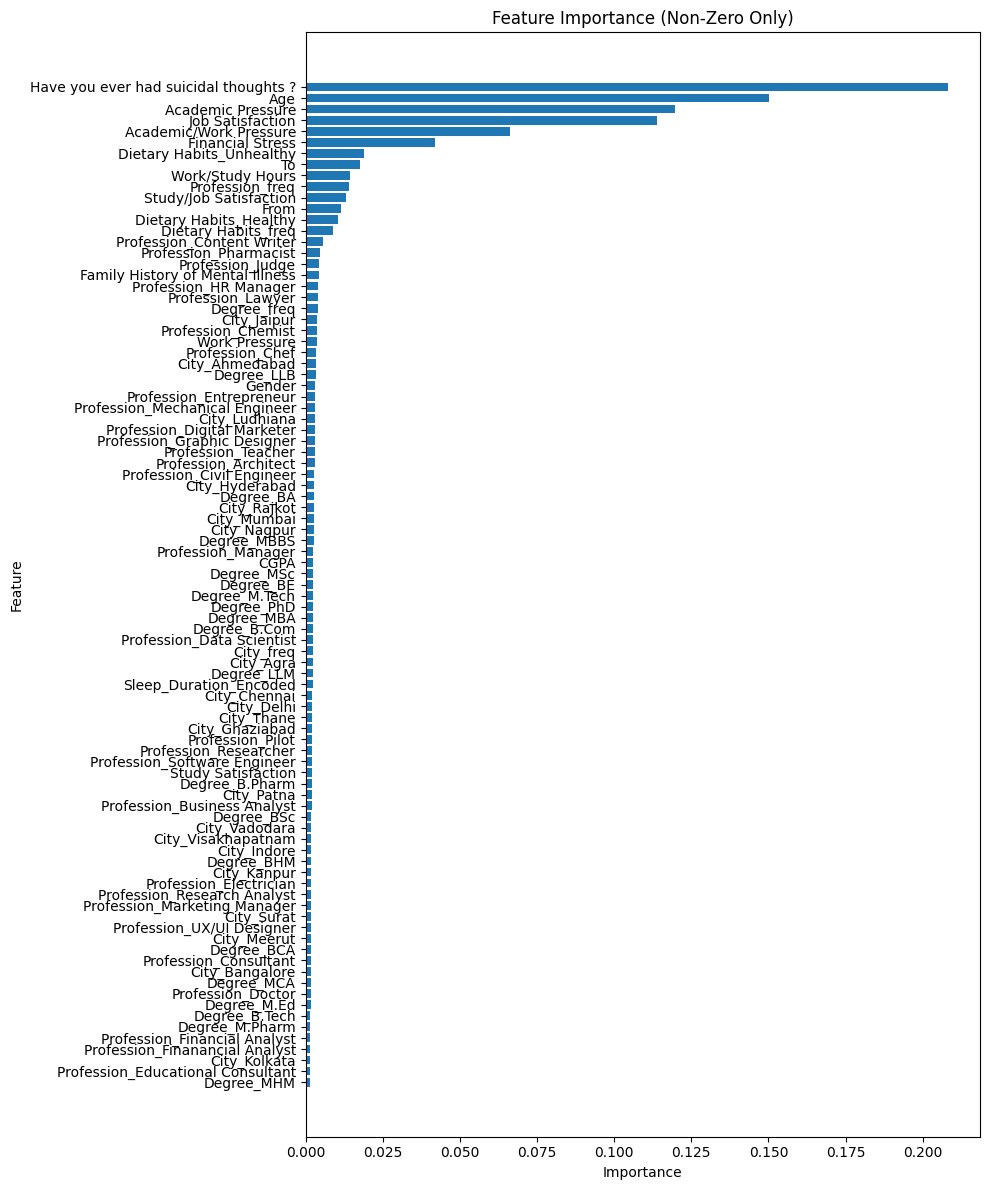

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
feature_importance = xgb_model1.feature_importances_

# Convert to a DataFrame for easier filtering and visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Filter to keep only features with non-zero importance
important_features = feature_importance_df[feature_importance_df['Importance'] > 0]

# Sort features by importance for better visualization
important_features = important_features.sort_values(by='Importance', ascending=False)

# Plot the remaining important features
plt.figure(figsize=(10, 12))
plt.barh(important_features['Feature'], important_features['Importance'])
plt.title("Feature Importance (Non-Zero Only)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert y-axis to display the most important at the top
plt.tight_layout()
plt.show()
